# Tutorial 7: Exploring unimodal data (RNA-seq)

Tutorial 7 demonstrates how to analyze unimodal single-cell data with Ocelli. The proposed workflow uses topic modeling to find relationships between features (topics). Ocelli treats each topic as a separate modality consisting of features that are highly specific to a topic. Using topic-based modalities reduces noise of single-cell data.

Data for this tutorial is available on [figshare](https://doi.org/10.6084/m9.figshare.28303937.v1). Download the data and import necessary packages.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import ocelli as oci
import anndata as ad
import scvelo as scv
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.sparse import load_npz


! wget --content-disposition https://figshare.com/ndownloader/articles/28303937/versions/1
! unzip -o 28303937.zip
! rm 28303937.zip

--2025-01-29 18:50:51--  https://figshare.com/ndownloader/articles/28303937/versions/1
54.170.28.5, 52.17.87.113, 2a05:d018:1f4:d000:2b52:700c:3d58:74bf, ...
Connecting to figshare.com (figshare.com)|54.170.28.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1541369807 (1.4G) [application/zip]
Saving to: ‘28303937.zip’

28303937.zip        100%[===================>]   1.43G  17.7MB/s    in 85s     

2025-01-29 18:52:17 (17.2 MB/s) - ‘28303937.zip’ saved [1541369807/1541369807]

Archive:  28303937.zip
 extracting: ipscs_reprogramming_rna.h5ad  
 extracting: ipscs_reprogramming_signature_Pluripotency.csv  
 extracting: ipscs_reprogramming_signature_XEN.csv  
 extracting: ipscs_reprogramming_WOT.npz  
 extracting: pancreas_rna.h5ad       


## Pancreatic endocrinogenesis (RNA-seq)

You will analyze a RNA-seq dataset consisting of pancreatic developmental cells sampled from embryonic day 15.5. Data was generated by [Bastidas-Ponce et al., 2019](https://journals.biologists.com/dev/article/146/12/dev173849/19483/Comprehensive-single-cell-mRNA-profiling-reveals-a). We filtered a count matrix available on [scVelo's website](https://scvelo.readthedocs.io/en/stable/scvelo.datasets.pancreas/#scvelo.datasets.pancreas).

### Loading and processing data

Load the data and compute LDA topics (loaded data includes 20 precomputed topics). Data consists of 3,696 cells and 5,465 cells. The count matrix is stored in `adata.X`.

In [2]:
pan = oci.read.h5ad('pancreas_rna.h5ad')
#oci.pp.lda(pan, n_components=20, verbose=1, max_iter=50, n_jobs=50, random_state=17)

pan

AnnData object with n_obs × n_vars = 3696 × 5465
    obs: 'celltype'
    uns: 'X_lda_params'
    obsm: 'X_lda'
    varm: 'X_lda'
    layers: 'spliced', 'unspliced'

Training MDM on the RNA-seq's LDA embedding would result in standard, unimodal Diffusion Maps. While such an approach is perfectly valid, LDA provides additional information - variational parameters for gene-topic distribution. You can interpret these parameters as a pseudo count representing the assignment of genes to a topic. `oci.pp.LDA` saves these parameters to `adata.varm['X_lda']` as an array of shape `(n_var, n_topics)`.

In [3]:
pan.varm['X_lda'].shape

(5465, 20)

Ocelli treats topics as modalities. `oci.pp.modality_generation` looks at parameters in `pan.varm['lda']` and assigns each gene to its highest-parameter topic. Grouped genes form new latent modalities. You can control the upper bound of the number of genes in each modality - the default value is 100. New modalities get log-normalized if `log_norm=True`.

In [4]:
oci.pp.generate_modalities(pan, verbose=True)

[modality0]	Modality generated.
[modality1]	Modality generated.
[modality2]	Modality generated.
[modality3]	Modality generated.
[modality4]	Modality generated.
[modality5]	Modality generated.
[modality6]	Modality generated.
[modality7]	Modality generated.
[modality8]	Modality generated.
[modality9]	Modality generated.
[modality10]	Modality generated.
[modality11]	Modality generated.
[modality12]	Modality generated.
[modality13]	Modality generated.
[modality14]	Modality generated.
[modality15]	Modality generated.
[modality16]	Modality generated.
[modality17]	Modality generated.
[modality18]	Modality generated.
[modality19]	Modality generated.
20 topic-based modalities generated.


``oci.pp.modality_generation`` automatically saves generated modality names to ``pan.uns['modalities']``.

In [5]:
pan.uns['modalities']

['modality0',
 'modality1',
 'modality2',
 'modality3',
 'modality4',
 'modality5',
 'modality6',
 'modality7',
 'modality8',
 'modality9',
 'modality10',
 'modality11',
 'modality12',
 'modality13',
 'modality14',
 'modality15',
 'modality16',
 'modality17',
 'modality18',
 'modality19']

`pan` includes unspliced and spliced gene expression layers. Employ them to calculate RNA velocities on 1,000 log-normalized highly variable genes. 

In [6]:
scv.pp.normalize_per_cell(pan, counts_per_cell_after=10000)
scv.pp.filter_genes_dispersion(pan, n_top_genes=1000)
scv.pp.log1p(pan)

scv.tl.velocity(pan, mode='stochastic')
scv.tl.velocity_graph(pan)

Normalized count data: X, spliced, unspliced.
Extracted 1000 highly variable genes.


/tmp/ipykernel_540930/2656978917.py:3: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(pan)


computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


### Multimodal Diffusion Maps

Log-normalized modalities are ready for training a MDM model. The critical step in the analysis is to use LDA's cell-topic distribution (`pan.obsm['X_lda']`) as modalities' weights. It is a natural choice because distribution values 1) sum to 1 for each cell and 2) encode a degree of relevance of each modality (topic) to a cell. The significant advantage of such an approach is that a cell's embedding is influenced by topic-based modalities (consisting of topic-relevant genes) proportionally to the topics' relevance to a cell. This step dramatically reduces inherent single-cell noise.

`oci.pp.modality_generation` saves LDA-based weights to `pan.obsm['weights']`.

In [7]:
pan.obsm['weights']

,modality0,modality1,modality2,modality3,modality4,modality5,modality6,modality7,modality8,modality9,modality10,modality11,modality12,modality13,modality14,modality15,modality16,modality17,modality18,modality19
AAACCTGAGAGGGATA,0.002430,0.007674,0.007712,0.102145,0.002342,0.008317,0.001827,0.017973,0.007638,0.063900,0.049555,0.042434,0.094664,0.024815,0.079300,0.009830,0.371567,0.043714,0.020644,0.041521
AAACCTGAGCCTTGAT,0.001912,0.278708,0.002602,0.087956,0.001166,0.012176,0.001074,0.104506,0.012574,0.006301,0.026456,0.004610,0.243986,0.020106,0.000990,0.132102,0.003261,0.005555,0.032054,0.021906
AAACCTGAGGCAATTA,0.003665,0.012536,0.014184,0.013503,0.002706,0.020714,0.027890,0.077708,0.015388,0.063211,0.071690,0.151815,0.131225,0.030949,0.011694,0.034146,0.243392,0.008848,0.016192,0.048543
AAACCTGCATCATCCC,0.001046,0.118428,0.002715,0.029078,0.001066,0.012884,0.000936,0.110373,0.087123,0.003526,0.058260,0.003513,0.121219,0.007089,0.000843,0.418786,0.002353,0.003590,0.012426,0.004745
AAACCTGGTAAGTGGC,0.001827,0.010498,0.011332,0.030509,0.001866,0.085311,0.001635,0.018233,0.009816,0.182690,0.056825,0.012112,0.048607,0.120583,0.002015,0.012569,0.036090,0.297624,0.054869,0.004990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGTGACATA,0.001140,0.006241,0.021874,0.041146,0.001111,0.009308,0.001104,0.057680,0.013975,0.166825,0.046281,0.067421,0.092043,0.092049,0.000877,0.008964,0.200480,0.118638,0.042896,0.009948
TTTGTCAAGTGTGGCA,0.001294,0.002969,0.003524,0.102868,0.001158,0.113681,0.001086,0.025608,0.007960,0.009393,0.034449,0.004601,0.035406,0.106191,0.000895,0.118450,0.004743,0.262046,0.156797,0.006881
TTTGTCAGTTGTTTGG,0.002135,0.405979,0.002980,0.081686,0.001517,0.039509,0.001331,0.144264,0.009441,0.008396,0.067988,0.004884,0.069425,0.016991,0.001272,0.090794,0.003418,0.006730,0.022281,0.018983
TTTGTCATCGAATGCT,0.001022,0.002333,0.002794,0.117173,0.315331,0.025995,0.044490,0.095125,0.007444,0.020210,0.007918,0.129767,0.056801,0.009333,0.016400,0.022803,0.005755,0.028691,0.008228,0.082386


Calculate the MDM representation.

In [8]:
oci.pp.neighbors(pan, n_neighbors=20, n_jobs=50, verbose=True)
oci.tl.MDM(pan, n_components=25, random_state=17, n_jobs=50, verbose=True)

[modality0]	20 nearest neighbors calculated.
[modality1]	20 nearest neighbors calculated.
[modality2]	20 nearest neighbors calculated.
[modality3]	20 nearest neighbors calculated.
[modality4]	20 nearest neighbors calculated.
[modality5]	20 nearest neighbors calculated.
[modality6]	20 nearest neighbors calculated.
[modality7]	20 nearest neighbors calculated.
[modality8]	20 nearest neighbors calculated.
[modality9]	20 nearest neighbors calculated.
[modality10]	20 nearest neighbors calculated.
[modality11]	20 nearest neighbors calculated.
[modality12]	20 nearest neighbors calculated.
[modality13]	20 nearest neighbors calculated.
[modality14]	20 nearest neighbors calculated.
[modality15]	20 nearest neighbors calculated.
[modality16]	20 nearest neighbors calculated.
[modality17]	20 nearest neighbors calculated.
[modality18]	20 nearest neighbors calculated.
[modality19]	20 nearest neighbors calculated.


2025-01-29 18:52:41,719	INFO worker.py:1518 -- Started a local Ray instance.


[modality0]	Unimodal Markov chain calculated.
[modality1]	Unimodal Markov chain calculated.
[modality2]	Unimodal Markov chain calculated.
[modality3]	Unimodal Markov chain calculated.
[modality4]	Unimodal Markov chain calculated.
[modality5]	Unimodal Markov chain calculated.
[modality6]	Unimodal Markov chain calculated.
[modality7]	Unimodal Markov chain calculated.
[modality8]	Unimodal Markov chain calculated.
[modality9]	Unimodal Markov chain calculated.
[modality10]	Unimodal Markov chain calculated.
[modality11]	Unimodal Markov chain calculated.
[modality12]	Unimodal Markov chain calculated.
[modality13]	Unimodal Markov chain calculated.
[modality14]	Unimodal Markov chain calculated.
[modality15]	Unimodal Markov chain calculated.
[modality16]	Unimodal Markov chain calculated.
[modality17]	Unimodal Markov chain calculated.
[modality18]	Unimodal Markov chain calculated.
[modality19]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
25 Mu

### Visualizing MDM components

Compute a 2D FLE and plot it.

In [9]:
oci.pp.neighbors(pan, x=['X_mdm'], n_neighbors=100, n_jobs=50, verbose=True)
oci.tl.transitions_graph(pan, x='X_mdm', transitions='velocity_graph', n_edges=20,
                         n_jobs=50, verbose=True)
oci.tl.fa2(pan, n_components=2, random_state=17, n_jobs=50)

[X_mdm]	100 nearest neighbors calculated.
Transitions-based graph constructed.


Jan 29, 2025 6:52:56 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Jan 29, 2025 6:52:56 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 3,696 (3,696 added)
Jan 29, 2025 6:52:56 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 73,920 (70,815 added)


*************************25%
*************************50%
*************************75%
*************************100%
Time = 23.626s


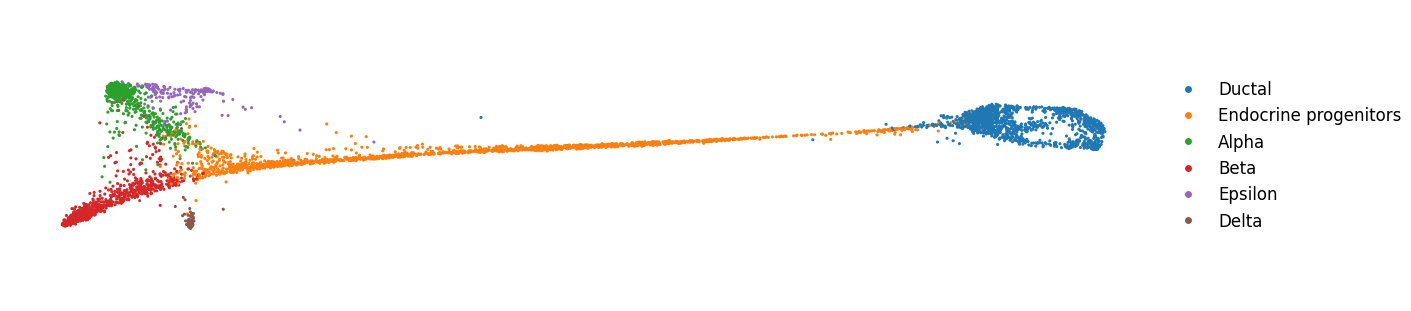

In [10]:
cdict = {'Ductal': '#1f77b4',
         'Endocrine progenitors': '#ff7f0e', 
         'Alpha': '#2ca02c', 
         'Beta': '#d62728', 
         'Epsilon': '#9467bd', 
         'Delta': '#8c564b'}

oci.pl.scatter(pan, x='X_fa2', c='celltype', cdict=cdict, s=5, title='', 
               fontsize=12, figsize=(14, 3))

The developmental process of the analyzed system has two significant stages:

* proliferating ductal cells that give rise to endocrine progenitors
* endocrine progenitors differentiating into four lineages: Alpha, Beta, Epsilon, and Delta.

### Reconstructing the cell cycle of Ductal cells

Investigate the cell cycle of proliferative Ductal cells. The cell cycle consists of four repeating phases:

* M: mitosis (cell division),
* G1: cell growth,
* S: DNA synthesis,
* G2: cell growth and preparation for mitosis.

You can validate the cell cycle reconstruction by checking scores for cell cycle phases.

In [11]:
scv.tl.score_genes_cell_cycle(pan)

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


Plot scores for phase S.

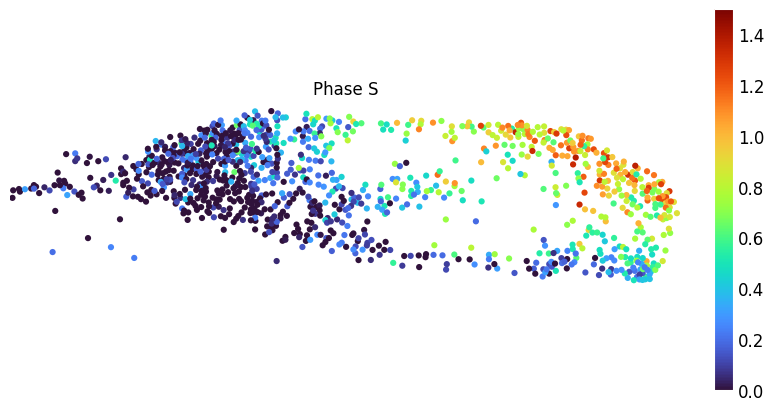

In [12]:
oci.pl.scatter(pan, x='X_fa2', c='S_score', cmap='turbo', s=20, vmin=0, 
               vmax=1.5, title='Phase S', xlim=[9500, 13300], ylim=[-200, 900], 
               figsize=(8, 4), fontsize=12)

Plot scores for combined phases G2 and M.

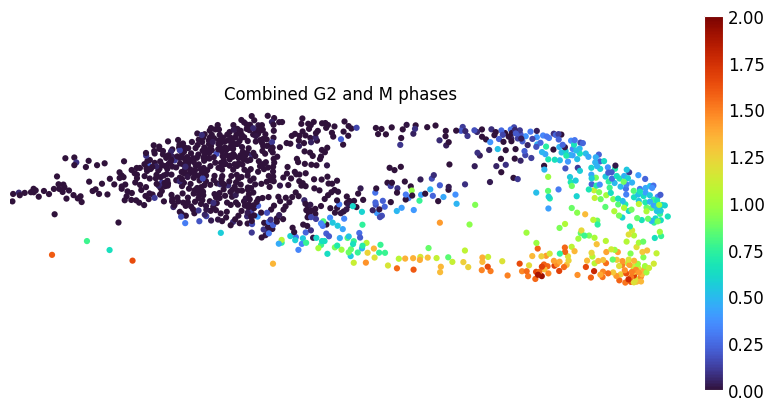

In [13]:
oci.pl.scatter(pan, x='X_fa2', c='G2M_score', cmap='turbo', s=20, vmin=0, 
               vmax=2, xlim=[9500, 13300], ylim=[-200, 900], figsize=(8, 4),
               title='Combined G2 and M phases', fontsize=12)

Arrows of the velocity stream should point from high S-scoring cells toward high G2M-scoring cells.

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_fa2', embedded velocity vectors (adata.obsm)


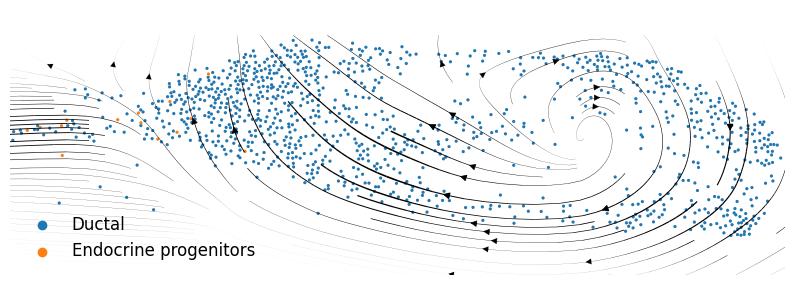

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

scv.pl.velocity_embedding_stream(pan, basis='fa2', alpha=1, title='', density=4, 
                                 xlim=[9500, 13300], ylim=[-300, 1000], linewidth=1, 
                                 legend_fontsize=12, size=20, legend_loc='best', 
                                 groups=['Ductal', 'Endocrine progenitors'], 
                                 show=False, ax=ax,color='celltype', palette=cdict, 
                                 cutoff_perc=0)

ax.set_aspect('equal')

### Tracing the development of endocrine cells

Endocrine cells are derived from endocrine progenitors and form four significant lineages (studied in detail [here](https://www.nature.com/articles/s41422-021-00486-w)):

* glucagon-producing Alpha cells,
* insulin-producing Beta cells,
* somatostatin-producing Delta cells,
* ghrelin-producing Epsilon cells.

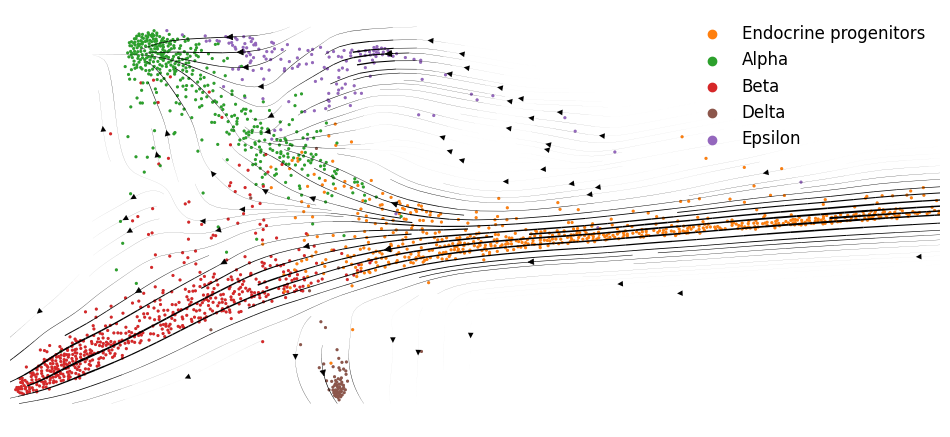

In [15]:
celltypes = ['Endocrine progenitors', 'Alpha', 'Beta', 'Delta', 'Epsilon']

fig, ax = plt.subplots(figsize=(12, 6))

scv.pl.velocity_embedding_stream(pan, basis='fa2', alpha=1, title='', density=3, 
                                 legend_fontsize=12, xlim=[-8800, -1000], 
                                 ylim=[-2000, 1500], linewidth=1., size=20, 
                                 legend_loc='best', groups=celltypes, show=False, 
                                 ax=ax, color='celltype', palette=cdict, cutoff_perc=0)

ax.set_aspect('equal')

## iPSCs reprogramming (RNA-seq)

The second part of tutorial tackles the analysis of a cell reprogramming RNA-seq dataset. Cell reprogramming is a complex biological process aiming to convert cells to induced pluripotent stem cells (iPSCs) before differentiation into diverse cell types.

The dataset is by [Schiebinger et al., 2019](https://www.sciencedirect.com/science/article/pii/S009286741930039X). The authors obtained Mouse Embryonic Fibroblasts (MEFs) from a single female embryo. They plated MEFs in serum, added Dox on day 0, withdrew Dox on day 8, and transferred cells to either serum-free N2B27 2i medium or maintained them in serum. Hence experiment can be split into Phase 1 (Dox) and Phase 2 (two separate conditions: 2i or serum). Phase 2 lasted till day 18. In this tutorial, you will explore Phase 2's cells in serum condition.

### Loading and processing data

During data preparation, we ran the [Velocyto](http://velocyto.org) on [raw bam files](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE115943), concatenated the resulting loom files into a single h5ad file and filtered it.

Load the data and compute LDA topics (loaded data includes 20 precomputed topics). The dataset consists of 68,703 cells and 16,817 genes.

In [16]:
rep = oci.read.h5ad('ipscs_reprogramming_rna.h5ad')
#oci.pp.lda(rep, n_components=20, max_iter=30, random_state=17, n_jobs=50, verbose=1)

rep

AnnData object with n_obs × n_vars = 68703 × 16817
    obs: 'origin', 'day'
    uns: 'X_lda_params', 'modalities', 'vars_0', 'vars_1', 'vars_10', 'vars_11', 'vars_12', 'vars_13', 'vars_14', 'vars_15', 'vars_16', 'vars_17', 'vars_18', 'vars_19', 'vars_2', 'vars_3', 'vars_4', 'vars_5', 'vars_6', 'vars_7', 'vars_8', 'vars_9'
    obsm: 'X_lda', 'modality0', 'modality1', 'modality10', 'modality11', 'modality12', 'modality13', 'modality14', 'modality15', 'modality16', 'modality17', 'modality18', 'modality19', 'modality2', 'modality3', 'modality4', 'modality5', 'modality6', 'modality7', 'modality8', 'modality9', 'weights'
    varm: 'X_lda'

Generate latent topic-based modalities.

In [17]:
oci.pp.generate_modalities(rep, verbose=True)

[modality0]	Modality generated.
[modality1]	Modality generated.
[modality2]	Modality generated.
[modality3]	Modality generated.
[modality4]	Modality generated.
[modality5]	Modality generated.
[modality6]	Modality generated.
[modality7]	Modality generated.
[modality8]	Modality generated.
[modality9]	Modality generated.
[modality10]	Modality generated.
[modality11]	Modality generated.
[modality12]	Modality generated.
[modality13]	Modality generated.
[modality14]	Modality generated.
[modality15]	Modality generated.
[modality16]	Modality generated.
[modality17]	Modality generated.
[modality18]	Modality generated.
[modality19]	Modality generated.
20 topic-based modalities generated.


Recall that LDA-based weights are saved in `rep.obsm['weights']`.

In [18]:
rep.obsm['weights']

,modality0,modality1,modality2,modality3,modality4,modality5,modality6,modality7,modality8,modality9,modality10,modality11,modality12,modality13,modality14,modality15,modality16,modality17,modality18,modality19
D10.5_serum_C2_ACGAGCCAGAGATGAG-1,0.018188,0.260103,0.001156,0.009126,0.009408,0.002352,0.029163,0.045946,0.008769,0.022036,0.151197,0.005858,0.002627,0.000785,0.001326,0.002444,0.003475,0.338802,0.083638,0.003604
D10.5_serum_C2_ACAGCTACACTCAGGC-1,0.414483,0.122275,0.001270,0.011122,0.003406,0.002281,0.019959,0.008085,0.003003,0.001095,0.013913,0.007186,0.003591,0.000837,0.001802,0.003269,0.003553,0.277199,0.095757,0.005914
D10.5_serum_C2_AATCCAGGTTAAGAAC-1,0.039830,0.059276,0.002651,0.047478,0.007964,0.014001,0.055219,0.108916,0.004528,0.048911,0.438464,0.014975,0.005923,0.001792,0.009630,0.005973,0.007042,0.034602,0.085691,0.007135
D10.5_serum_C2_AAGGAGCTCGCCAGCA-1,0.253508,0.140598,0.002646,0.023050,0.086551,0.007178,0.023440,0.262014,0.005271,0.032513,0.037204,0.013520,0.005346,0.001750,0.003070,0.021574,0.009583,0.008264,0.037694,0.025226
D10.5_serum_C2_AACGTTGCAAGCCCAC-1,0.030916,0.168546,0.001561,0.004111,0.002640,0.040235,0.091436,0.011523,0.001359,0.003263,0.016181,0.018611,0.004810,0.000868,0.098846,0.007633,0.003684,0.343449,0.144181,0.006150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D9_serum_C2_TTTGTCATCGGTCTAA-1,0.002453,0.031560,0.002408,0.002175,0.219085,0.011649,0.026991,0.008321,0.014884,0.008861,0.096890,0.481740,0.030356,0.001679,0.002245,0.008400,0.021435,0.003019,0.003191,0.022657
D9_serum_C2_TTTGCGCTCTGGTGTA-1,0.002147,0.036475,0.001062,0.000824,0.471827,0.002695,0.001489,0.002531,0.001406,0.005953,0.092982,0.349954,0.004608,0.000769,0.000802,0.011202,0.008510,0.001127,0.000868,0.002770
D9_serum_C2_TTTGGTTAGCGTTCCG-1,0.001865,0.030482,0.002234,0.001204,0.339076,0.005374,0.010248,0.003357,0.008745,0.004399,0.030197,0.464910,0.017090,0.001260,0.001305,0.005885,0.058622,0.001956,0.003050,0.008741
D9_serum_C2_TTTGGTTCACATCCAA-1,0.002554,0.042005,0.003658,0.001548,0.261153,0.010440,0.015073,0.004557,0.062262,0.010299,0.122122,0.346567,0.020403,0.002564,0.001558,0.017506,0.043661,0.003329,0.017770,0.010971


### Multimodal Diffusion Maps

Run MDM to create a multimodal representation of the dataset with LDA-based weights.

In [19]:
oci.pp.neighbors(rep, n_neighbors=20, n_jobs=100, verbose=True)
oci.tl.MDM(rep, n_components=20, save_eigvec=True, save_eigval=True, random_state=17,
           n_jobs=100, verbose=True)

[modality0]	20 nearest neighbors calculated.
[modality1]	20 nearest neighbors calculated.
[modality2]	20 nearest neighbors calculated.
[modality3]	20 nearest neighbors calculated.
[modality4]	20 nearest neighbors calculated.
[modality5]	20 nearest neighbors calculated.
[modality6]	20 nearest neighbors calculated.
[modality7]	20 nearest neighbors calculated.
[modality8]	20 nearest neighbors calculated.
[modality9]	20 nearest neighbors calculated.
[modality10]	20 nearest neighbors calculated.
[modality11]	20 nearest neighbors calculated.
[modality12]	20 nearest neighbors calculated.
[modality13]	20 nearest neighbors calculated.
[modality14]	20 nearest neighbors calculated.
[modality15]	20 nearest neighbors calculated.
[modality16]	20 nearest neighbors calculated.
[modality17]	20 nearest neighbors calculated.
[modality18]	20 nearest neighbors calculated.
[modality19]	20 nearest neighbors calculated.


2025-01-29 19:16:11,674	INFO worker.py:1518 -- Started a local Ray instance.


[modality0]	Unimodal Markov chain calculated.
[modality1]	Unimodal Markov chain calculated.
[modality2]	Unimodal Markov chain calculated.
[modality3]	Unimodal Markov chain calculated.
[modality4]	Unimodal Markov chain calculated.
[modality5]	Unimodal Markov chain calculated.
[modality6]	Unimodal Markov chain calculated.
[modality7]	Unimodal Markov chain calculated.
[modality8]	Unimodal Markov chain calculated.
[modality9]	Unimodal Markov chain calculated.
[modality10]	Unimodal Markov chain calculated.
[modality11]	Unimodal Markov chain calculated.
[modality12]	Unimodal Markov chain calculated.
[modality13]	Unimodal Markov chain calculated.
[modality14]	Unimodal Markov chain calculated.
[modality15]	Unimodal Markov chain calculated.
[modality16]	Unimodal Markov chain calculated.
[modality17]	Unimodal Markov chain calculated.
[modality18]	Unimodal Markov chain calculated.
[modality19]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
20 Mu

### Visualizing MDM components with Waddington Optimal Transport

For hair follicle and pancreatic endocrinogenesis datasets, you used scVelo's cell transitions to boost the FLE. However, Ocelli can use transitions from any algorithm. Below, you will apply [Waddington Optimal Transport's](https://www.sciencedirect.com/science/article/pii/S009286741930039X) (WOT) precomputed transitions (available in the [*transport maps*](https://broadinstitute.github.io/wot/tutorial/) tutorial). We've merged precomputed transitions into a single sparse matrix.

Load WOT transitions.

In [20]:
rep.uns['WOT'] = load_npz('ipscs_reprogramming_WOT.npz')

Generate a 3D FLE using WOT transitions. You can pass a additional cell timestamp key (from `adata.obs['day']`) to `oci.tl.transitions_graph`. This way, during graph construction, if there are not enough non-zero transitions in a cell's MDM neighborhood, the remaining graph edges connect to the nearest MDM neighbors from the subsequent timestamp, not the global ones.

In [21]:
oci.pp.neighbors(rep, x=['X_mdm'], n_neighbors=100, n_jobs=100, verbose=True)
oci.tl.transitions_graph(rep, x='X_mdm', transitions='WOT', timestamps='day',
                         n_edges=10, n_jobs=100, verbose=True)

oci.tl.fa2(rep, n_components=3, n_iter=15000, n_jobs=100, random_state=17)

[X_mdm]	100 nearest neighbors calculated.


23it [00:08,  2.68it/s]


Transitions-based graph constructed.


Jan 29, 2025 7:18:27 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Jan 29, 2025 7:18:29 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 68,703 (68,703 added)
Jan 29, 2025 7:18:29 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 687,030 (607,465 added)


*************************25%
*************************50%
*************************75%
*************************100%
Time = 1182.973s


Visualize a 3D FLE from multiple perspectives.

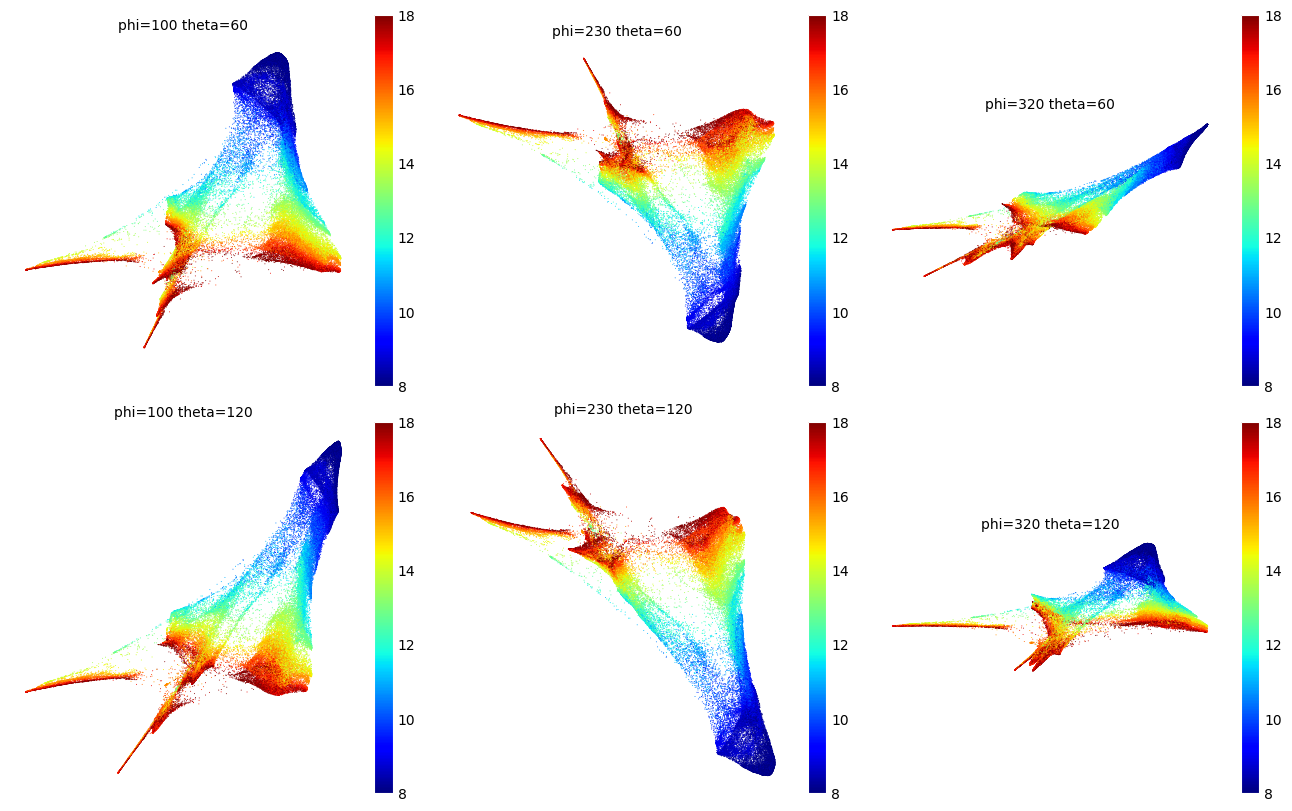

In [22]:
oci.pl.projections(rep, x='X_fa2', c='day', phis=[100, 230, 320], thetas=[60, 120],
                   s=0.5, cmap='jet', fontsize=10, figsize=(13, 8))

### Tracing the developmental ancestors of iPSCs

In this tutorial section, you will investigate the development of induced pluripotent stem cells (iPSCs). First, locate pluripotent cells by calculating z-scores for a pluripotency gene signature by [Schiebinger et al., 2019](https://www.sciencedirect.com/science/article/pii/S009286741930039X).

In [23]:
# define a custom colormap
cmap = LinearSegmentedColormap.from_list(
    'custom', ['#e3e3e3','#e3e3e3', '#ff0000', '#000000'], N=256)

# load the raw count matrix and log-normalize it
rep_sig = oci.read.h5ad('ipscs_reprogramming_rna.h5ad')
sc.pp.normalize_total(rep_sig, target_sum=10000)
sc.pp.log1p(rep_sig)

# load a gene signature
markers = list(pd.read_csv('ipscs_reprogramming_signature_Pluripotency.csv', header=None)[0])

# save a list of all gene names
var_names = list(rep_sig.var.index)

def get_indices(signature, varnames):
    indices = list()
    for gene in signature:
        if gene in varnames:
            indices.append(varnames.index(gene))

    return indices

# get marker indices
marker_indices = get_indices(markers, var_names)

# compute z-scores
oci.tl.zscores(rep_sig, markers=marker_indices, out='Pluripotency')

# save z-scores to rep
rep.obs['Pluripotency'] = rep_sig.obs['Pluripotency']

2025-01-29 19:38:27,827	INFO worker.py:1518 -- Started a local Ray instance.


Plot pluripotency z-scores on the selected projection.

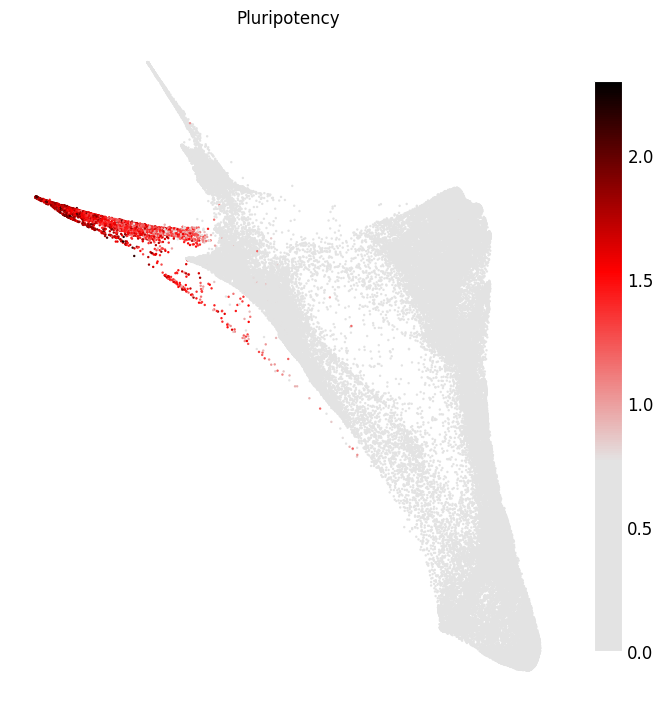

In [24]:
# project a 3D FLE onto a plane
oci.tl.projection(rep, x='X_fa2', phi=230, theta=125)

oci.pl.scatter(rep, x='X_proj', c='Pluripotency', cmap=cmap, s=3,
               markerscale=2, fontsize=12, figsize=(7, 7), title='Pluripotency',
               vmin=0)

You have located pluripotent cells. Mark 1% of cells with the highest pluripotency z-scores.

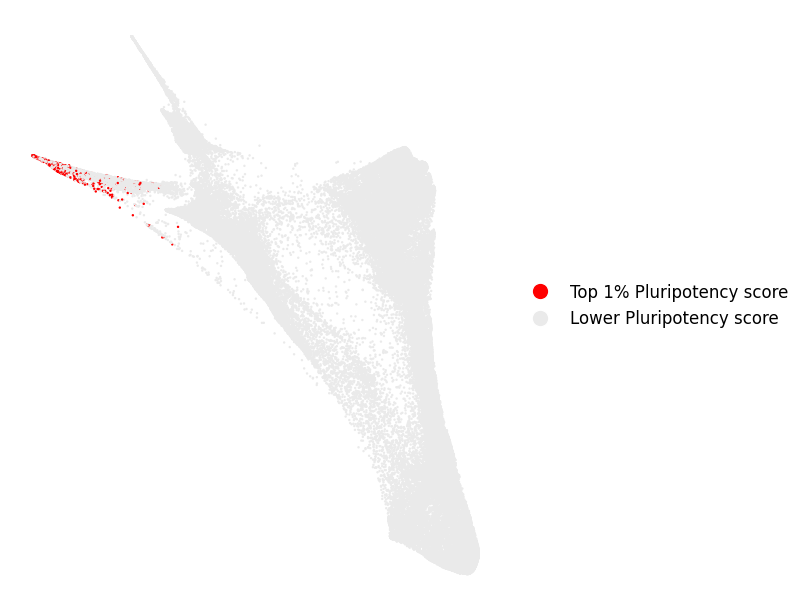

In [25]:
thr = np.percentile(rep.obs['Pluripotency'], 99)

mask_Pluripotency = list()
for v in rep.obs['Pluripotency']:
    if v > thr:
        mask_Pluripotency.append('Top 1% Pluripotency score')
    else:
        mask_Pluripotency.append('Lower Pluripotency score')
rep.obs['mask_Pluripotency'] = mask_Pluripotency

cdict = {'Top 1% Pluripotency score': '#ff0000', 
         'Lower Pluripotency score': '#eaeaea'}

oci.pl.scatter(rep, x='X_proj', c='mask_Pluripotency', cdict=cdict, s=3, 
               markerscale=2, fontsize=12, figsize=(8, 6), title='', vmin=0)

Create a vector with 1s assigned to 1% of cells with the highest z-scores and 0s to others.

In [26]:
v = np.asarray([1 if val == 'Top 1% Pluripotency score' else 0 for val in rep.obs['mask_Pluripotency']])

Trace the developmental ancestors of pluripotent cells by iteratively diffusing `v` with the square WOT transition matrix `M`. `t`-step diffusion can be written as `M^t * v`.

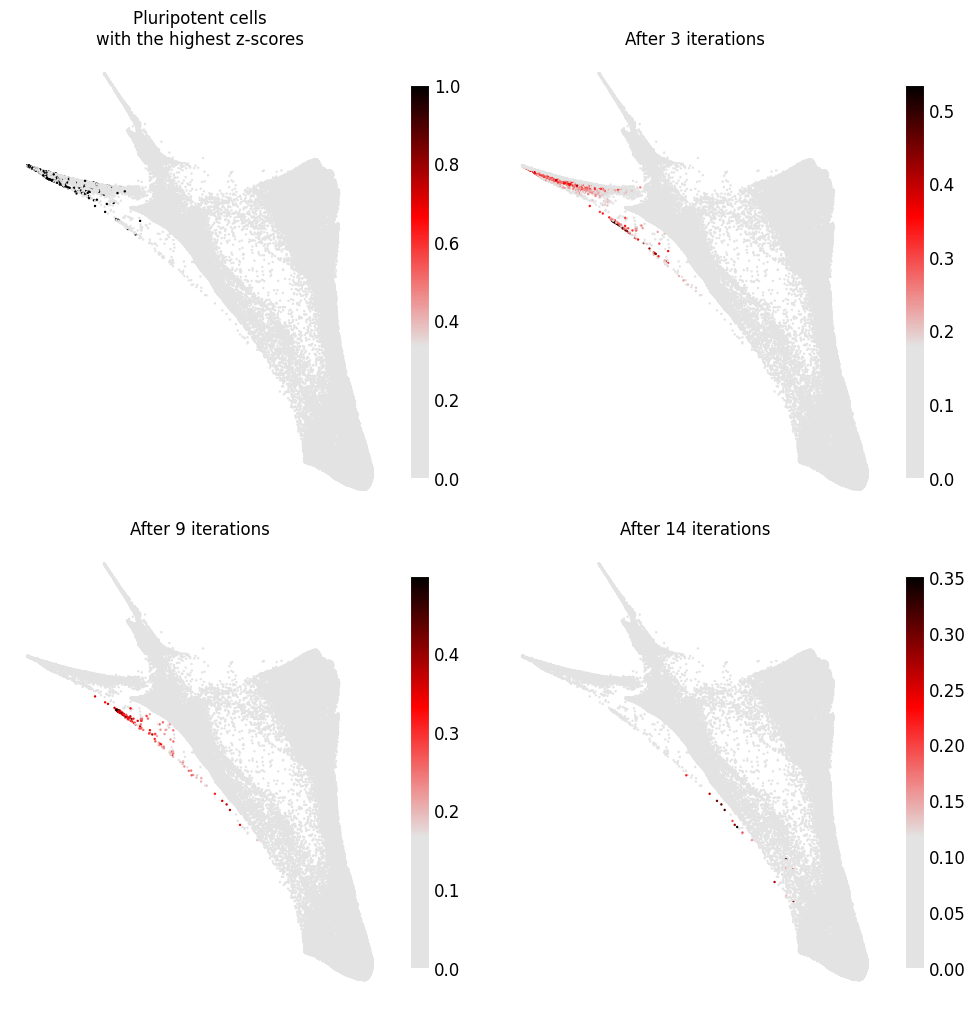

In [27]:
n_iterations = 14
M = rep.uns['WOT']

vs = [v]

for i in range(n_iterations):
    v = M.dot(v)
    if i in [2, 8, 13]:
        vs.append(v)
    
rep.obsm['ancestors'] = pd.DataFrame(np.asarray(vs).T, 
                                       index=rep.obs.index,
                                       columns=['Pluripotent cells\nwith the highest z-scores',
                                                'After 3 iterations',
                                                'After 9 iterations', 
                                                'After 14 iterations'])

oci.pl.scatter(rep, x='X_proj', c='ancestors', cmap=cmap, s=3,
               markerscale=0.05, fontsize=12, figsize=(10, 10), vmin=0, ncols=2)

MDM reconstructed a clear ancestor trajectory of iPSCs in serum condition.

### Sensitivity to rare cell populations

Lastly, compute and plot z-scores for the gene signature from [Schiebinger et al., 2019](https://www.sciencedirect.com/science/article/pii/S009286741930039X) of a rare population of XEN cells.

2025-01-29 19:39:03,783	INFO worker.py:1518 -- Started a local Ray instance.


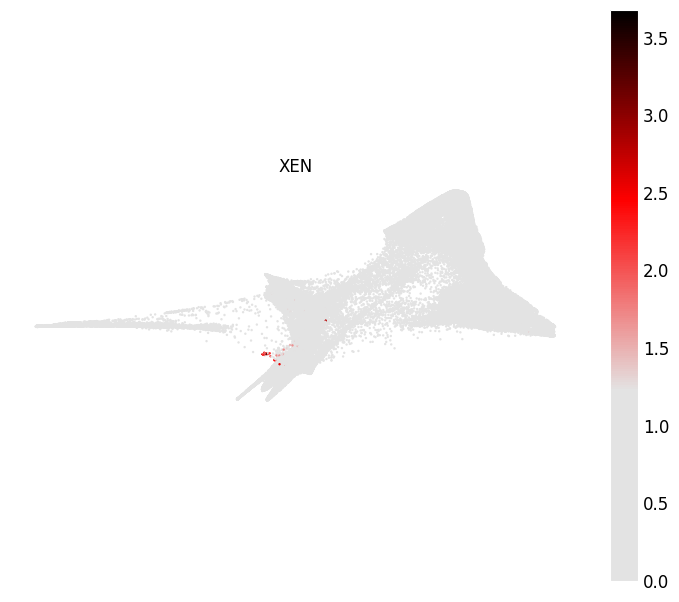

In [28]:
oci.tl.projection(rep, x='X_fa2', phi=320, theta=120)

markers = list(pd.read_csv('ipscs_reprogramming_signature_XEN.csv', header=None)[0])
oci.tl.zscores(rep_sig, markers=get_indices(markers, var_names), out='XEN')
rep.obs['XEN'] = rep_sig.obs['XEN']

oci.pl.scatter(rep, x='X_proj', c='XEN', cmap=cmap, s=3, markerscale=2,
               fontsize=12, figsize=(7, 6), title='XEN', vmin=0)

This wraps up the tutorial. Good luck with your analyses!